# Medical Insurance Analysis

# `Table of Contents:`
- <a href=#read>Data Reading</a>
    - <a href=#munging>Data Munging</a>
    - <a href=#visual>Data Visualisation</a><br><br>
- <a href=#prepare>Data Preparation</a><br><br>
- <a href=#build>Model Building</a>
    - <a href=#res>Residual Analysis</a>
    - <a href=#eval>Model Evaluation</a><br><br>
- <a href=#conclusion>Conclusion</a>

In [1]:
# importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score,mean_squared_error
import warnings
warnings.filterwarnings('ignore')

<a id=read></a>
## Reading Data

In [2]:
insurance = pd.read_csv("insurance.csv")
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Understanding data

In [3]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
print(insurance['smoker'].unique())
print(insurance['sex'].unique())
print(insurance['region'].unique())

['yes' 'no']
['female' 'male']
['southwest' 'southeast' 'northwest' 'northeast']


In [5]:
insurance.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

<a id=munging></a>
### Data Munging

***Variables Description & Operations***
- to be scaled
    - age
    - bmi
    - children
    - charges
- to be converted
    - sex
        - 1 female
        - 0 male
    - smoker
        - 1 smoker
        - 0 non-smoker
    - region - dummy variable creation

In [6]:
insurance['smoker'] = insurance.smoker.apply(lambda x: 1 if x=='yes' else 0)
insurance.smoker.value_counts()

0    1064
1     274
Name: smoker, dtype: int64

In [7]:
insurance['sex'] = insurance.sex.apply(lambda x: 1 if x=='female' else 0)
insurance.sex.value_counts()

0    676
1    662
Name: sex, dtype: int64

<a id=visual></a>
### Data Visualisation

#### Visualising numerical variables

In [8]:
plt.style.available
plt.style.use('fivethirtyeight')

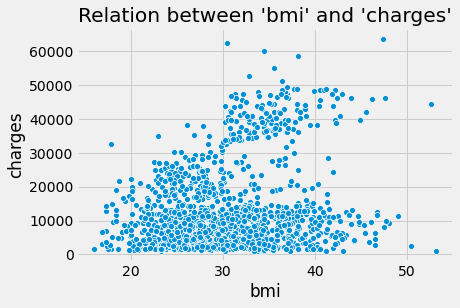

In [9]:
sns.scatterplot(insurance.bmi,insurance.charges)
plt.title("Relation between 'bmi' and 'charges'")
plt.show()

**`Inference`**:
- There is a **positive correlation** between bmi and charges

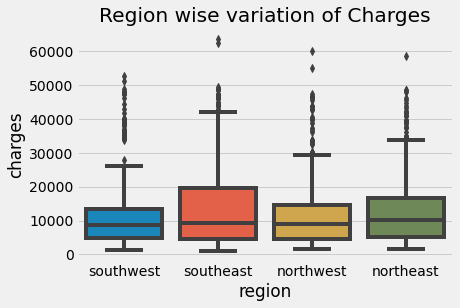

In [10]:
sns.boxplot(insurance.region,insurance.charges)
plt.title("Region wise variation of Charges")
plt.show()

**`Inference`**:
- All the regions have almost same median.
- The souteast region has some extreme outliers in terms of charges.

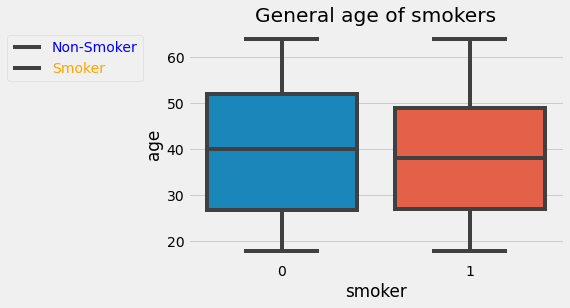

In [11]:
sns.boxplot(insurance.smoker,insurance.age)
plt.legend(['Non-Smoker','Smoker'],bbox_to_anchor=(-0.1,1),labelcolor=['b','orange'])
plt.title('General age of smokers')
plt.show()

**`Inference`**:
- Non Smokers tend to have greater age than that of Smoker in the Inter-quartile range.

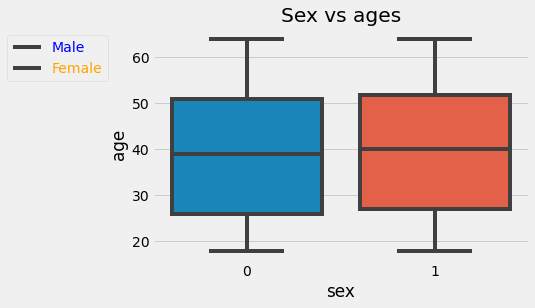

In [12]:
sns.boxplot(insurance.sex,insurance.age)
plt.legend(['Male','Female'],bbox_to_anchor=(-0.1,1),labelcolor=['b','orange'])
plt.title('Sex vs ages')
plt.show()

**`Inference`**:
- Both the genders have almost similar medians and Inter-quartile range.

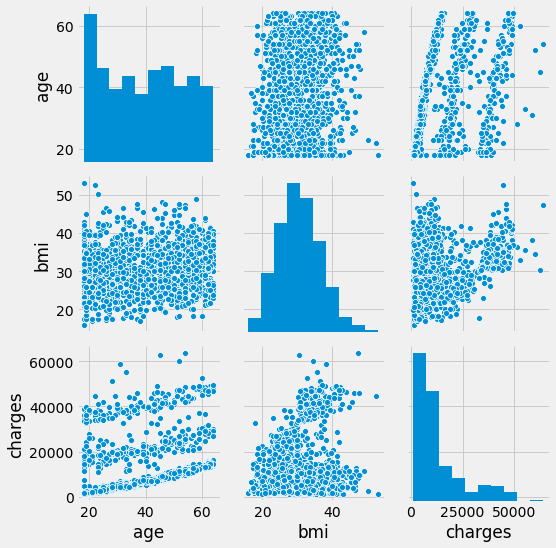

In [13]:
sns.pairplot(insurance[['age','bmi','charges']])
plt.show()

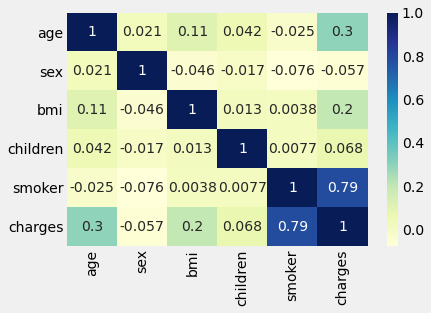

In [14]:
sns.heatmap(insurance.corr(),cmap="YlGnBu",annot=True)
plt.show()

<a id=prepare></a>
## Data Preparation

In [15]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   int64  
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   int64  
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(4), object(1)
memory usage: 73.3+ KB


In [16]:
#converting region column to dummy variables
pd1 = pd.get_dummies(insurance.region,drop_first=True)
insurance = pd.concat([insurance,pd1],axis=1)
# pd1

In [17]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges,northwest,southeast,southwest
0,19,1,27.900,0,1,southwest,16884.92400,0,0,1
1,18,0,33.770,1,0,southeast,1725.55230,0,1,0
2,28,0,33.000,3,0,southeast,4449.46200,0,1,0
3,33,0,22.705,0,0,northwest,21984.47061,1,0,0
4,32,0,28.880,0,0,northwest,3866.85520,1,0,0


In [18]:
# dropping the region column for feeding data to regression model
insurance.drop('region',axis=1,inplace=True)

In [19]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        1338 non-null   int64  
 1   sex        1338 non-null   int64  
 2   bmi        1338 non-null   float64
 3   children   1338 non-null   int64  
 4   smoker     1338 non-null   int64  
 5   charges    1338 non-null   float64
 6   northwest  1338 non-null   uint8  
 7   southeast  1338 non-null   uint8  
 8   southwest  1338 non-null   uint8  
dtypes: float64(2), int64(4), uint8(3)
memory usage: 66.8 KB


#### Splitting data into train set and test set

In [20]:
df_train,df_test = train_test_split(insurance,train_size=0.7,random_state=100)

In [21]:
print(df_train.shape)
print(df_test.shape)

(936, 9)
(402, 9)


#### Rescaling the variables

In [22]:
scaler=MinMaxScaler()
insurance.describe()
# df_train.head()
num_vars=['age','bmi','children','charges']
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

In [23]:
df_train.describe()

,age,sex,bmi,children,smoker,charges,northwest,southeast,southwest
count,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000
mean,0.458171,0.502137,0.399088,0.220513,0.194444,0.192301,0.244658,0.282051,0.242521
std,0.306065,0.500263,0.167115,0.241223,0.395984,0.193690,0.430114,0.450239,0.428837
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.173913,0.000000,0.277441,0.000000,0.000000,0.055033,0.000000,0.000000,0.000000
50%,0.456522,1.000000,0.391176,0.200000,0.000000,0.129662,0.000000,0.000000,0.000000
75%,0.717391,1.000000,0.512039,0.400000,0.000000,0.245247,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Checking the correlation among the variables for Feature Scaling

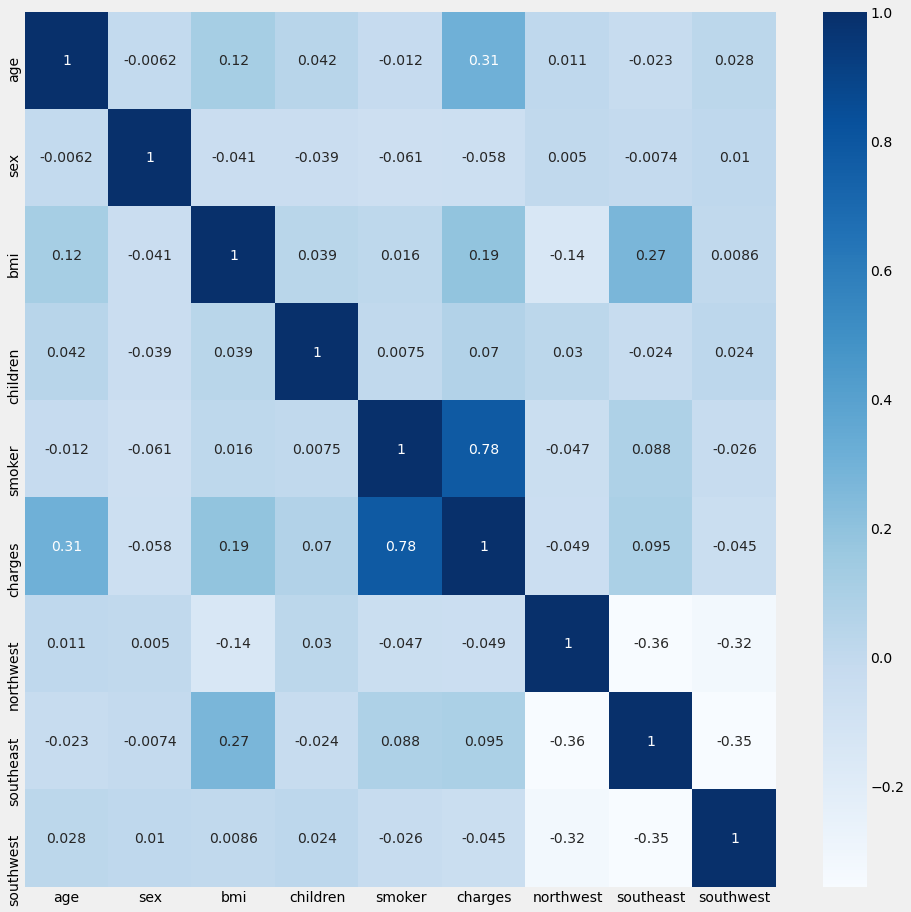

In [24]:
plt.figure(figsize=(15,15))
sns.heatmap(df_train.corr(),cmap="Blues",annot=True)
plt.show()

<a id=build></a>
## Model Building

### Manual Feature Selection
- applying Forward Selection Technique

In [25]:
y_train=df_train.pop('charges')
X_train=df_train

In [26]:
X_train_sm = sm.add_constant(X_train[['smoker','age','bmi','children']])
lm_model = sm.OLS(y_train,X_train_sm).fit()
print(lm_model.params)
print(lm_model.summary())

const      -0.043460
smoker      0.382820
age         0.190729
bmi         0.164917
children    0.036829
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     648.2
Date:                Thu, 03 Dec 2020   Prob (F-statistic):          2.76e-267
Time:                        23:19:58   Log-Likelihood:                 831.76
No. Observations:                 936   AIC:                            -1654.
Df Residuals:                     931   BIC:                            -1629.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------

In [27]:
vif = pd.DataFrame()
vif['Features'] = X_train_sm.columns
vif['VIF'] = [variance_inflation_factor(X_train_sm.values,i).round(3) for i in range(X_train_sm.shape[1])]
vif.sort_values('VIF',ascending=False,inplace=True)
vif

,Features,VIF
0,const,9.017
2,age,1.016
3,bmi,1.016
4,children,1.003
1,smoker,1.001


<a id=res></a>
### Residual Analysis

#### Residual Analysis for training predictions

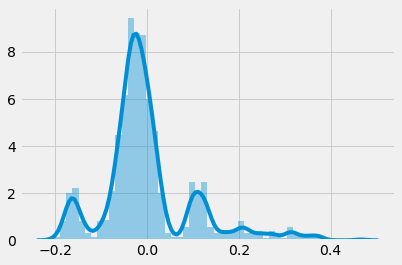

In [28]:
y_pred_train = lm_model.predict(X_train_sm)
res = y_train - y_pred_train
sns.distplot(res)
plt.show()

In [29]:
r2_score(y_train,y_pred_train)

0.7358069665177005

#### Making Predictions

In [30]:
df_test[num_vars] = scaler.transform(df_test[num_vars])
y_test = df_test.pop('charges')
X_test = df_test
X_test_sm = sm.add_constant(X_test[['smoker','age','bmi','children']])

In [31]:
y_test_pred = lm_model.predict(X_test_sm)

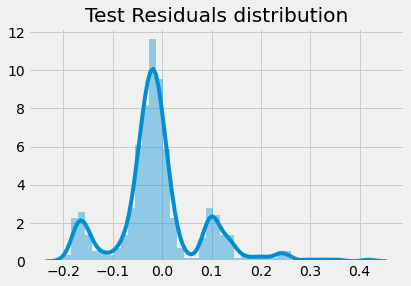

In [32]:
res_test = y_test-y_test_pred
sns.distplot(res_test)
plt.title("Test Residuals distribution")
plt.show()

<a id=eval></a>
### Model Evaluation

In [33]:
print('r2 score ---',r2_score(y_test,y_test_pred))
print('Root Mean Squared Error ---',mean_squared_error(y_test,y_test_pred))

r2 score --- 0.7801257218275263
Root Mean Squared Error --- 0.008134147231801161


**`Inference`**:
- r$^{2}$ score for the predicted **test data is 78%** as comapared to the **training dataset 73.58%%**
- **RMSE has come out to be very low i.e 0.0081** which implies that the model is good for making predictions

<a id=conclusion></a>
## `Conclusion:`
- **Data Visualisation**:
    - There is a positive correlation between bmi and charges.
    - The souteast region has some extreme outliers in terms of charges.
    - Non Smokers tend to have greater age than that of Smoker in the Inter-quartile range.
    - Both the genders have almost similar medians and Inter-quartile range.
- **Data Preparation**:
    - 'age','bmi','children','charges' are scaled using the ***Normalization*** scaling technique.
    - 'region', 'sex', 'smoker' variables are converted from categorical to dummy variables.
- **Model Building**:
    - ***Forward Selection Technique*** is used for manual feature selection.
- **Model Evaluation**:
    - **r$^{2}$** score for testing data seems to be greater than training data.
        - **Training data: 0.74**
        - **Testing data: 0.78**
    - **Root Mean Square Error** for testing prediction is also small, which inferences that our **model is good in predicting values**.
        - **Testing data: 0.0081**